In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/data_for_train_test.csv')
df = df.dropna(subset=['reviews'])

Using device: cuda


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Epoch 1 | Train Loss: 5.0557 | Val Loss: 4.0502 | Avg Acc: 0.6627
Epoch 2 | Train Loss: 4.1007 | Val Loss: 3.6867 | Avg Acc: 0.7106
Epoch 3 | Train Loss: 3.4343 | Val Loss: 3.5044 | Avg Acc: 0.7312
Epoch 4 | Train Loss: 3.0229 | Val Loss: 3.1041 | Avg Acc: 0.7534
Epoch 5 | Train Loss: 2.7574 | Val Loss: 3.0864 | Avg Acc: 0.7611
Epoch 6 | Train Loss: 2.5046 | Val Loss: 2.9848 | Avg Acc: 0.7637
Epoch 7 | Train Loss: 2.3137 | Val Loss: 2.9135 | Avg Acc: 0.7723
Epoch 8 | Train Loss: 2.1599 | Val Loss: 2.7890 | Avg Acc: 0.7731
Epoch 9 | Train Loss: 2.0287 | Val Loss: 2.8257 | Avg Acc: 0.7646
Epoch 10 | Train Loss: 1.9601 | Val Loss: 2.8444 | Avg Acc: 0.7671


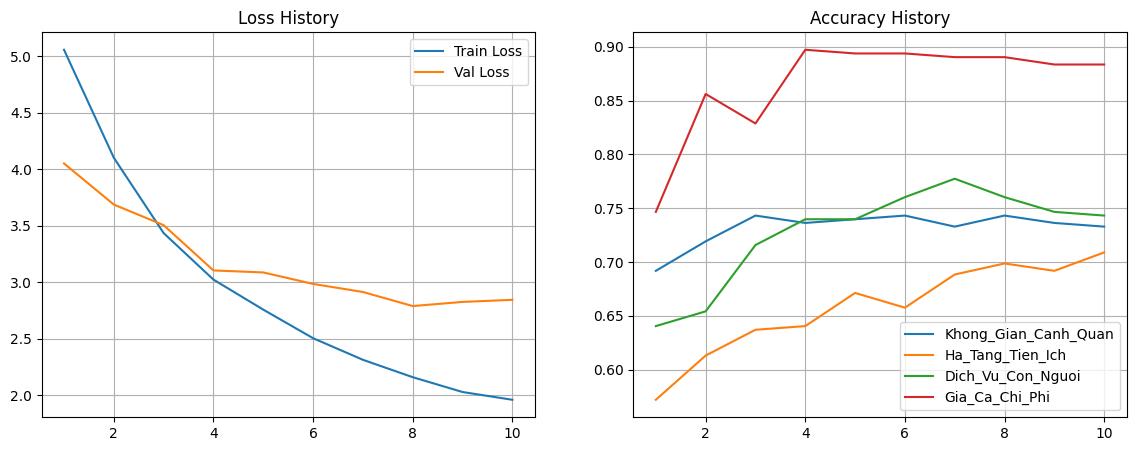


--- Khong_Gian_Canh_Quan ---
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       117
           1       0.50      0.24      0.32        21
           2       0.40      0.52      0.45        88
           3       0.88      0.85      0.87       359

    accuracy                           0.75       585
   macro avg       0.63      0.58      0.59       585
weighted avg       0.77      0.75      0.76       585


--- Ha_Tang_Tien_Ich ---
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       338
           1       0.59      0.66      0.62        70
           2       0.42      0.38      0.40        86
           3       0.54      0.49      0.52        91

    accuracy                           0.71       585
   macro avg       0.60      0.60      0.60       585
weighted avg       0.70      0.71      0.70       585


--- Dich_Vu_Con_Nguoi ---
               precision    recall  f1-score 

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import warnings
import os


warnings.filterwarnings("ignore")


# 1. CẤU HÌNH (CONFIGURATION)

CONFIG = {
    'model_name': 'vinai/phobert-base-v2',
    'max_len': 256,
    'batch_size': 16,
    'epochs': 10,
    'learning_rate': 2e-5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'data_path': '/content/data_for_train_test.csv',
    'num_classes': 4,
    'aspects': ['Khong_Gian_Canh_Quan', 'Ha_Tang_Tien_Ich', 'Dich_Vu_Con_Nguoi', 'Gia_Ca_Chi_Phi'],
    'seed': 42
}

def set_seed(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(CONFIG['seed'])
print(f"Using device: {CONFIG['device']}")


# 2. DATASET CLASS

class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.aspects = CONFIG['aspects']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        review = str(self.df.iloc[item]['reviews_ready'])
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        labels = self.df.iloc[item][self.aspects].values.astype(int)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }


# 3. MODEL ARCHITECTURE

class AspectClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.3):
        super(AspectClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.classifier(x)

class ABSAModel_Final(nn.Module):
    def __init__(self, n_classes=4, model_name='vinai/phobert-base-v2'):
        super(ABSAModel_Final, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        embed_dim = 768
        hidden_dim = 128
        self.drop_bert = nn.Dropout(p=0.3)

        self.head_khong_gian = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_ha_tang = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_dich_vu = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_gia_ca = AspectClassifier(embed_dim, hidden_dim, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask

        x = self.drop_bert(mean_pooled)
        return {
            'khong_gian': self.head_khong_gian(x),
            'ha_tang': self.head_ha_tang(x),
            'dich_vu': self.head_dich_vu(x),
            'gia_ca': self.head_gia_ca(x)
        }


# 4. TRAINING & EVALUATION FUNCTIONS

def loss_fn(outputs, targets):
    loss_fct = nn.CrossEntropyLoss()
    return (loss_fct(outputs['khong_gian'], targets[:, 0]) +
            loss_fct(outputs['ha_tang'], targets[:, 1]) +
            loss_fct(outputs['dich_vu'], targets[:, 2]) +
            loss_fct(outputs['gia_ca'], targets[:, 3]))

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    predictions = {k: [] for k in CONFIG['aspects']}
    real_values = {k: [] for k in CONFIG['aspects']}

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            preds_batch = [
                torch.max(outputs['khong_gian'], dim=1)[1],
                torch.max(outputs['ha_tang'], dim=1)[1],
                torch.max(outputs['dich_vu'], dim=1)[1],
                torch.max(outputs['gia_ca'], dim=1)[1]
            ]
            for i, aspect in enumerate(CONFIG['aspects']):
                predictions[aspect].extend(preds_batch[i].cpu().numpy())
                real_values[aspect].extend(targets[:, i].cpu().numpy())

    accuracies = {a: accuracy_score(real_values[a], predictions[a]) for a in CONFIG['aspects']}
    return np.mean(losses), accuracies, predictions, real_values

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    for aspect in CONFIG['aspects']:
        accs = [h[aspect] for h in history['val_acc_history']]
        plt.plot(epochs, accs, label=aspect)
    plt.title('Accuracy History')
    plt.legend(); plt.grid(True)
    plt.show()


# 5. MAIN

def main():
    df = pd.read_csv(CONFIG['data_path'])
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=CONFIG['seed'])
    df_val, df_test = train_test_split(df_temp, test_size=2/3, random_state=CONFIG['seed'])

    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    train_loader = DataLoader(ReviewDataset(df_train, tokenizer, CONFIG['max_len']), batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(ReviewDataset(df_val, tokenizer, CONFIG['max_len']), batch_size=CONFIG['batch_size'])
    test_loader = DataLoader(ReviewDataset(df_test, tokenizer, CONFIG['max_len']), batch_size=CONFIG['batch_size'])

    model = ABSAModel_Final().to(CONFIG['device'])
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * CONFIG['epochs'])

    history = {'train_loss': [], 'val_loss': [], 'val_acc_history': []}
    best_val_loss = float('inf')

    for epoch in range(CONFIG['epochs']):
        t_loss = train_epoch(model, train_loader, optimizer, scheduler, CONFIG['device'])
        v_loss, v_acc, _, _ = eval_model(model, val_loader, CONFIG['device'])

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['val_acc_history'].append(v_acc)

        print(f"Epoch {epoch+1} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Avg Acc: {np.mean(list(v_acc.values())):.4f}")

        if v_loss < best_val_loss:
            best_val_loss = v_loss
            torch.save(model.state_dict(), 'best_absa_model.bin')

    plot_history(history)

    # Test
    model.load_state_dict(torch.load('best_absa_model.bin'))
    _, t_acc, t_preds, t_targets = eval_model(model, test_loader, CONFIG['device'])
    for a in CONFIG['aspects']:
        print(f"\n--- {a} ---\n", classification_report(t_targets[a], t_preds[a], zero_division=0))

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel


# 1. ĐỊNH NGHĨA LẠI KIẾN TRÚC

class AspectClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.3):
        super(AspectClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.classifier(x)

class ABSAModel_Final(nn.Module):
    def __init__(self, n_classes=4, model_name='vinai/phobert-base-v2'):
        super(ABSAModel_Final, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        embed_dim = 768
        hidden_dim = 128
        self.drop_bert = nn.Dropout(p=0.3)

        self.head_khong_gian = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_ha_tang = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_dich_vu = AspectClassifier(embed_dim, hidden_dim, n_classes)
        self.head_gia_ca = AspectClassifier(embed_dim, hidden_dim, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask
        x = self.drop_bert(mean_pooled)
        return {
            'khong_gian': self.head_khong_gian(x),
            'ha_tang': self.head_ha_tang(x),
            'dich_vu': self.head_dich_vu(x),
            'gia_ca': self.head_gia_ca(x)
        }


# 2. HÀM DỰ ĐOÁN

def predict(text, model, tokenizer, device, max_len=256):
    model.eval()

    # Map nhãn số sang text cho dễ đọc
    label_map = {0: "Không nhắc đến", 1: "Tiêu cực", 2: "Trung tính", 3: "Tích cực"}
    aspects = ['Khong_Gian_Canh_Quan', 'Ha_Tang_Tien_Ich', 'Dich_Vu_Con_Nguoi', 'Gia_Ca_Chi_Phi']

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

        results = {}
        for aspect_name, logit in outputs.items():
            # Lấy index của class có xác suất cao nhất
            _, prediction = torch.max(logit, dim=1)
            results[aspect_name] = label_map[prediction.item()]

    return results


# 3.LOAD VÀ TEST

# Cấu hình
MODEL_PATH = 'best_absa_model.bin'
MODEL_NAME = 'vinai/phobert-base-v2'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Khởi tạo Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = ABSAModel_Final().to(DEVICE)

# Kiểm tra nếu file model tồn tại thì mới load
import os
if os.path.exists(MODEL_PATH):
    # LOAD MODEL
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"--- Đã load model thành công từ {MODEL_PATH} ---")

    # TEST
    test_comment = "Cảnh quan ở đây rất đẹp, nhân viên phục vụ nhiệt tình nhưng giá vé hơi đắt và đường đi hơi khó khăn."
    print(f"\nCâu test: '{test_comment}'")

    predictions = predict(test_comment, model, tokenizer, DEVICE)

    print("\nKết quả dự đoán:")
    for aspect, sentiment in predictions.items():
        print(f"- {aspect.replace('_', ' ')}: {sentiment}")
else:
    print(f"LỖI: Không tìm thấy file {MODEL_PATH}. Bạn cần chạy cell training trước.")

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Đã load model thành công từ best_absa_model.bin ---

Câu test: 'Cảnh quan ở đây rất đẹp, nhân viên phục vụ nhiệt tình nhưng giá vé hơi đắt và đường đi hơi khó khăn.'

Kết quả dự đoán:
- khong gian: Tích cực
- ha tang: Tiêu cực
- dich vu: Tích cực
- gia ca: Trung tính
